In [1]:
import os
import pandas
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.patches as mpatches
from IPython.display import display, HTML
import geopandas as gpd
import time
import io
from pprint import pprint
os.chdir('/home/idies/workspace/Temporary/raddick/cra_scratch/')
print(os.getcwd())
outdir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/'
print(outdir)
shapefiledir = '/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/'
print(shapefiledir)
print('DONE')

/home/idies/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/idies/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


/home/idies/workspace/Temporary/raddick/cra_scratch
/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/
/home/idies/workspace/Storage/raddick/Baltimore/shapefiles/
DONE


## Load shapefiles

In [2]:
s = time.time()
print('reading shapefile...')

tract_shapes_gdf = gpd.read_file(shapefiledir+'census_tracts_2010/geo_export_c50bbe56-543e-4878-9c9f-c56be327600a.shp', encoding='utf-8')
tract_shapes_gdf = tract_shapes_gdf.assign(tractname = pandas.to_numeric(tract_shapes_gdf['name'].apply(lambda x: x.split(' ')[-1]), errors='coerce'))
tract_shapes_gdf = tract_shapes_gdf.set_index('tractname')
e = time.time()
print('Read {0:,.0f} Maryland census tracts in {1:.3f} seconds.'.format(len(tract_shapes_gdf), e-s))

print('Calculating percent white...')
tract_shapes_gdf = tract_shapes_gdf.assign(percent_white = tract_shapes_gdf['white'] / tract_shapes_gdf['population'])

print('\nreading city boundary...')
boundary_gdf = gpd.read_file(shapefiledir+'baltimore_city_polygon/baltimore_city_polygon.shp')

print('\nreading water features...')
water_gdf = gpd.read_file(shapefiledir+'water/water.shp', encoding='utf-8')
water_gdf = water_gdf.set_index('OBJECTID')

s = time.time()
print('\nreading street centerlines...')
streets_gdf = gpd.read_file(shapefiledir+'streets/streetcl.shp', encoding='utf-8')
e = time.time()
print('Read {0:,.0f} streets in {1:.3f} seconds.'.format(len(streets_gdf), e-s))

s = time.time()
streets_gdf = streets_gdf.drop('OBJECTID_1', axis=1)
streets_gdf = streets_gdf.set_index('OBJECTID')
print('Cutting off streets at city boundary...')
s = time.time()
streets_gdf = gpd.sjoin(streets_gdf, boundary_gdf, op='within')
e = time.time()
print('Remaining: {0:,.0f} streets after {1:,.0f} seconds of processing.'.format(len(streets_gdf), e-s))
#streets_gdf = gpd.overlay(streets_gdf, boundary_gdf, how='intersection')

#print('\nSetting CRSes...')
#for x in (boundary_gdf, water_gdf, streets_gdf):
#    x.crs = tract_shapes_gdf.crs

print('DONE')


reading shapefile...
Read 200 Maryland census tracts in 0.105 seconds.
Calculating percent white...

reading city boundary...

reading water features...

reading street centerlines...
Read 48,160 streets in 9.720 seconds.
Cutting off streets at city boundary...


/home/idies/miniconda3/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


Remaining: 47,642 streets after 14 seconds of processing.
DONE


# Lending by geography of borrowers

## Load all data

In [3]:
s = time.time()
baltimore_tracts_df = pandas.read_csv('tracts_processed.csv', encoding='utf-8', index_col='rownumber')
print('{0:,.0f} tract datas nationwide.'.format(len(baltimore_tracts_df)))
print('backing up...')
baltimore_tracts_df_bk = baltimore_tracts_df
e = time.time()
print('DONE in {0:,.0f} seconds.'.format(e-s))

/home/idies/miniconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:518: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


22,761,175 tract datas nationwide.
backing up...
DONE in 98 seconds.


## Select Baltimore City, convert income tract data to low/moderate/medium/high

In [4]:
print('retrieving from backup...')
baltimore_tracts_df = baltimore_tracts_df_bk

baltimore_tracts_df = baltimore_tracts_df[(baltimore_tracts_df['state'] == 24) & (baltimore_tracts_df['county'] == 510)]
print('{0:,.0f} tract datas in Baltimore.'.format(len(baltimore_tracts_df)))

#baltimore_tracts_df = baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y']
print('{0:,.0f} of them had loans.'.format(len(baltimore_tracts_df)))

print('Converting full level system to low/moderate/medium/upper...')
baltimore_tracts_df = baltimore_tracts_df.assign(cra_level = '')
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 1) & (x <=5))), 'cra_level'] = 'low'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 6) & (x <=8))), 'cra_level'] = 'moderate'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 9) & (x <=12))), 'cra_level'] = 'middle'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x == 13))), 'cra_level'] = 'upper'
baltimore_tracts_df.loc[(baltimore_tracts_df['income_group_total'].apply(lambda x: (x >= 14) & (x <=15))), 'cra_level'] = 'unknown'

print('backing up...')
baltimore_tracts_df_bk = baltimore_tracts_df
print('DONE')


retrieving from backup...
61,098 tract datas in Baltimore.
61,098 of them had loans.
Converting full level system to low/moderate/medium/upper...
backing up...
DONE


# Aggregate all loans within census tracts

In [5]:
print('retrieving from backup...')
baltimore_tracts_df = baltimore_tracts_df_bk

print('grouping...')

tractdata = baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y'].groupby(['census_tract', 'activity_year', 'institution_name']).size()

tractdata = tractdata.sort_index()
# Run this to get every index value to display in every row:
#pandas.set_option('display.multi_sparse', False)

# GET ALL ROWS THAT MATCH A GIVEN CRITERION FROM A GIVEN LEVEL
#tractdata.xs(101.00, level=0) #Access all loans given in census tract 101
#tractdata.xs('low', level=1) # Access all loans given to low income group 
#tractdata.xs(2016, level=2) # Access all loans given in 2016
#tractdata.xs('WELLS FARGO BANK, N.A. (CA)', level=3) # Access all loans given by Wells Fargo

# FIND NUMBER OF LOANS FOR EACH VALUE AT EACH LEVEL

#tractdata.groupby([pandas.Grouper(level='census_tract')]).sum() # Number of loans given in each census tract
#tractdata.groupby([pandas.Grouper(level='cra_level')]).sum() # Number of loans given at each CRA income level
#tractdata.groupby([pandas.Grouper(level='activity_year')]).sum() # Number of loans given per year
#tractdata.groupby([pandas.Grouper(level='institution_name')]).sum() # Number of loans given per institution


# ITERATE THROUGH VALUES OF AN INDEX LEVEL AND SEE THE GROUPS FORMED BY THOSE VALUES
#grouped_by_census_tract = tractdata.groupby('census_tract')
#for name, group in grouped_by_census_tract:
#    print(name)
#    print(group)
#    print('\n')

# ACCESS A GROUP ASSOCIATED WITH A SPECIFIC VALUE ONE ONE LEVEL...
#grouped_by_census_tract = tractdata.groupby('census_tract')
#grouped_by_census_tract.get_group(101.00)
# OR ON MULTIPLE LEVELS...
#tractdata.groupby(['census_tract', 'institution_name']).get_group((101, '1ST MARINER BANK (MD)')) # note get_group takes a tuple

print('backing up...')
tractdata_bk = tractdata

print('OK')
#tractdata

retrieving from backup...
grouping...
backing up...
OK


# Connect census tract aggregates with shapefiles

In [6]:
print('getting tract loan data from backup...')
tractdata = tractdata_bk

#tractdata
print('Grouping by tract only...')
grouped_by_census_tract = tractdata.groupby('census_tract').sum()

print('\nAdding loan data to shape data...')
tract_shapes_gdf = tract_shapes_gdf.assign(nLoans=grouped_by_census_tract)

#print('\nCalculating loans per 10,000 pepole...')
#tract_shapes_gdf = tract_shapes_gdf.assign(nLoansPer10k = (10000 * tract_shapes_gdf['nLoans']) / tract_shapes_gdf['population'])

print('matching up CSAs...')
tract_shapes_gdf = tract_shapes_gdf.to_crs(water_gdf.crs)

print('\nbacking up...')
tract_shapes_gdf_bk = tract_shapes_gdf

print('ok')

getting tract loan data from backup...
Grouping by tract only...

Adding loan data to shape data...
matching up CSAs...

backing up...
ok


# Examine two census tracts: 1207 (Charles Village) and 1403 (Druid Heights)

Figure saved


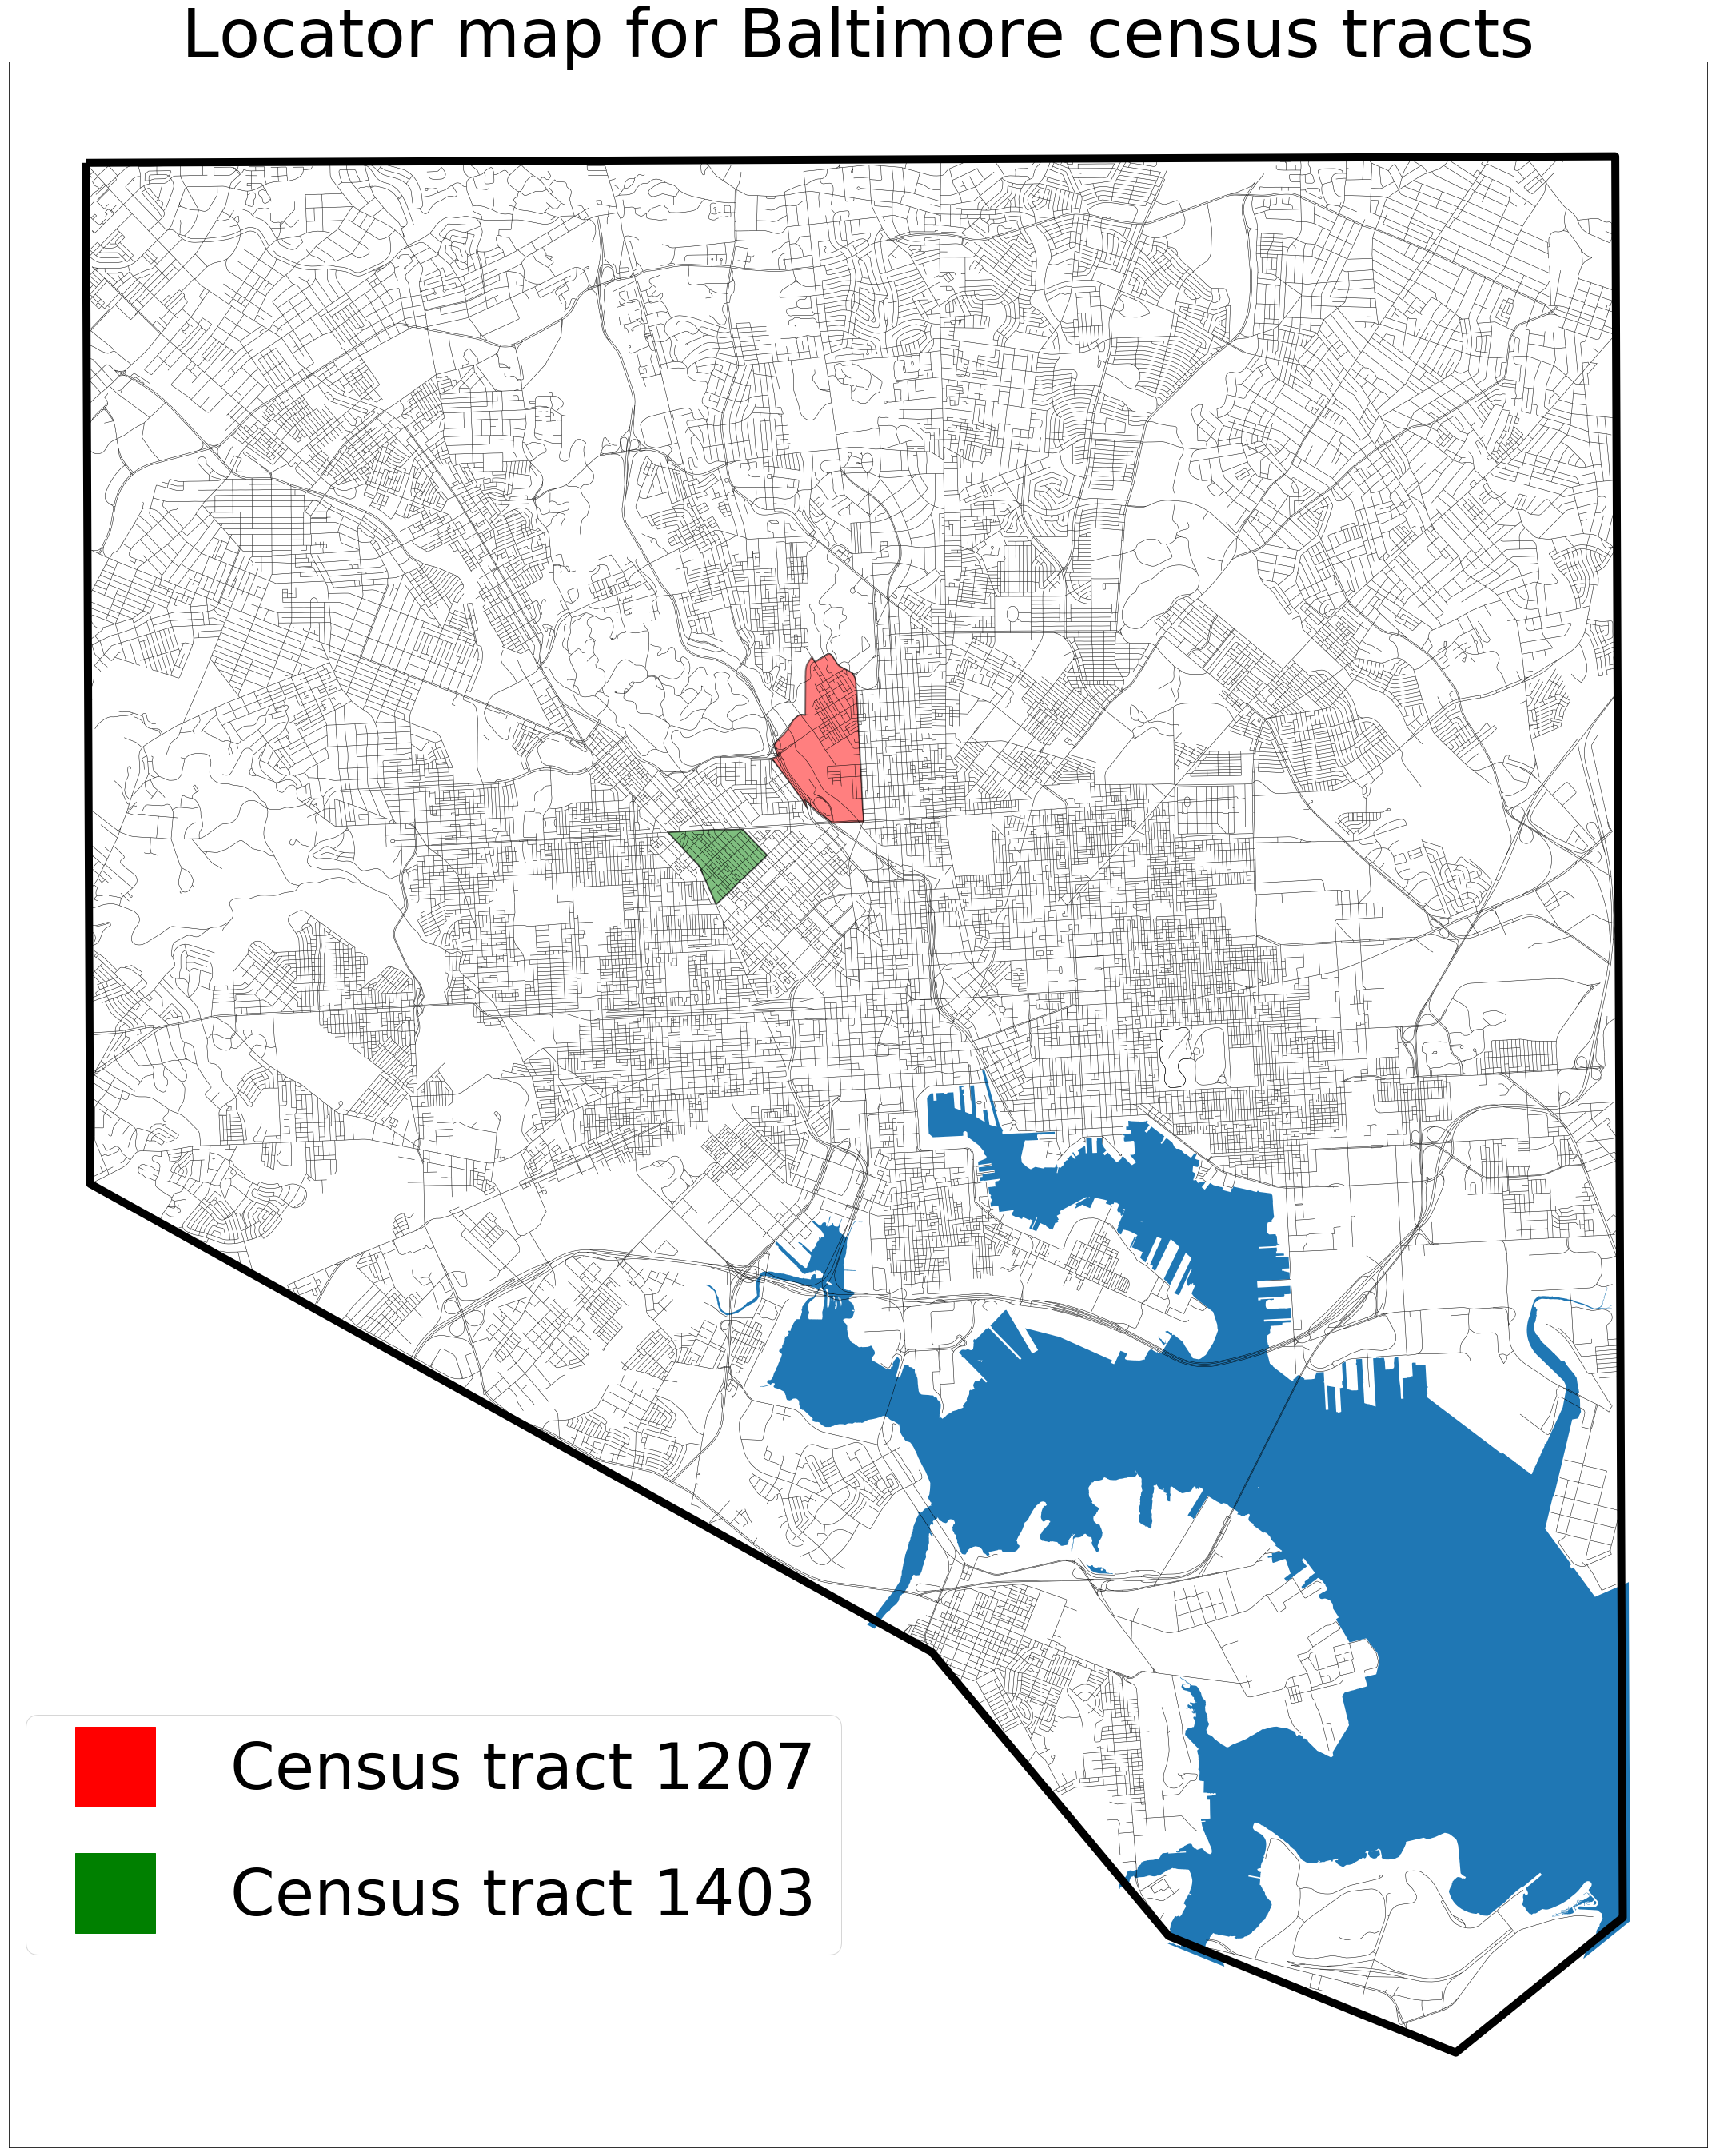

In [7]:
scale = 1
fig, ax = plt.subplots(figsize=(48*scale,48*scale))
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)

csa1 = tract_shapes_gdf[tract_shapes_gdf.index == 1207].plot(ax=ax, alpha=0.5, color='red', edgecolor='black', linewidth=2*scale)
csa2 = tract_shapes_gdf[tract_shapes_gdf.index == 1403].plot(ax=ax, alpha=0.5, color='green', edgecolor='black', linewidth=2*scale)

water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax)
boundary_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=10*scale)
streets_gdf.plot(ax=ax, color='black', linewidth=0.5*scale)

#https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
colors = ["r", "g"]
texts = ["Census tract 1207", "Census tract 1403"]
patches = [plt.plot([],[], marker="s", ms=100*scale, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.25, 0.15), 
           loc='center', ncol=1, numpoints=1, fontsize=80*scale, labelspacing=1*scale)
plt.title('Locator map for Baltimore census tracts', fontsize=84*scale)

plt.savefig(outdir+'figures/locator_1207_1403.svg', format='svg')
print('Figure saved')
#plt.show()

## Number of loans by assessment area for those census tracts

### Census tract 1207

In [8]:
loans_1207_by_assessment_area_s = pandas.Series(
    data=baltimore_tracts_df[baltimore_tracts_df['census_tract'] == 1207].fillna('none or unknown').groupby('assessment_area_number').size(), 
)
#loans_1207_by_assessment_area_s.name = 'nLoans'
loans_1207_by_assessment_area_df = pandas.DataFrame(data=loans_1207_by_assessment_area_s.values, columns=['nLoans'], index=loans_1207_by_assessment_area_s.index)
loans_1207_by_assessment_area_df

nLoans
assessment_area_number        
1.0                         74
2.0                         12
3.0                          6
4.0                          7
5.0                          5
6.0                          8
7.0                          3
8.0                          4
9.0                          3
10.0                         1
11.0                         2
13.0                         7
15.0                         3
17.0                         1
18.0                         3
19.0                        10
20.0                         2
25.0                         1
26.0                         2
30.0                         1
34.0                         4
36.0                         2
37.0                         1
41.0                         1
47.0                         1
51.0                        13
53.0                         1
57.0                         1
70.0                         1
71.0                         4
72.0                         1
73.0                         7
74.0                         2
76.0                         1
78.0                         1
84.0                         1
109.0                        1
110.0                        1
112.0                        1
129.0                        2
131.0                        2
140.0                        1
173.0                        1
174.0                        1
176.0                        1
177.0                        1
180.0                        1
1001.0                       1
2401.0                       1
4001.0                       1
none or unknown            140

### Census tract 1403

In [9]:
loans_1403_by_assessment_area_s = pandas.Series(
    data=baltimore_tracts_df[baltimore_tracts_df['census_tract'] == 1403].fillna('none or unknown').groupby('assessment_area_number').size(), 
)
loans_1403_by_assessment_area_df = pandas.DataFrame(data=loans_1403_by_assessment_area_s.values, columns=['nLoans'], index=loans_1403_by_assessment_area_s.index)
loans_1403_by_assessment_area_df

nLoans
assessment_area_number        
1.0                         74
2.0                         12
3.0                          6
4.0                          7
5.0                          5
6.0                          8
7.0                          3
8.0                          4
9.0                          3
10.0                         1
11.0                         2
13.0                         7
15.0                         3
17.0                         1
18.0                         3
19.0                        10
20.0                         2
25.0                         1
26.0                         2
30.0                         1
34.0                         4
36.0                         2
37.0                         1
41.0                         1
47.0                         1
51.0                        13
53.0                         1
57.0                         1
70.0                         1
71.0                         4
72.0                         1
73.0                         7
74.0                         2
76.0                         1
78.0                         1
84.0                         1
109.0                        1
110.0                        1
112.0                        1
129.0                        2
131.0                        2
140.0                        1
173.0                        1
174.0                        1
176.0                        1
177.0                        1
180.0                        1
1001.0                       1
2401.0                       1
4001.0                       1
none or unknown             87

## Number of loans by income group for those census tracts

### Census tract 1207

In [10]:
loans_1207_by_income_group_s = pandas.Series(
    data=baltimore_tracts_df[
        (baltimore_tracts_df['census_tract'] == 1207)
        & (baltimore_tracts_df['activity_year'] == 2016)
    ].fillna('none or unknown').groupby('income_group').size(), 
)
loans_1207_by_income_group_df = pandas.DataFrame(data=loans_1207_by_income_group_s.values, columns=['nLoans'], index=loans_1207_by_income_group_s.index)
loans_1207_by_income_group_df

nLoans
income_group             
50% to 60% of MFI      29

### Census tract 1403

In [11]:
loans_1403_by_income_group_s = pandas.Series(
    data=baltimore_tracts_df[baltimore_tracts_df['census_tract'] == 1403].fillna('none or unknown').groupby('income_group').size(), 
)
loans_1403_by_income_group_df = pandas.DataFrame(data=loans_1403_by_income_group_s.values, columns=['nLoans'], index=loans_1403_by_income_group_s.index)
loans_1403_by_income_group_df

nLoans
income_group             
40% to 50% of MFI     300

## List of all loans in those census tracts

### Census tract 1207

In [12]:
output = baltimore_tracts_df[[
    'census_tract', 'assessment_area_number', 'income_group', 'cra_level', 'institution_name'
]][baltimore_tracts_df['census_tract'] == 1207].fillna('').sort_values('income_group')

htmlString = '<table>'
htmlString += '<tr><th>Census tract</th><th>Assessment area</th><th>Income group</th><th>CRA level</th><th>Institution name</th></tr>'
for ix, thisrow in output.iterrows():
    htmlString += '<tr>'
    for thiscol in thisrow:
        htmlString += '<td>'+str(thiscol)+'</td>'
    htmlString += '<tr>'
htmlString += '</table>'

display(HTML(htmlString))

### Census tract 1403

In [ ]:
output = baltimore_tracts_df[[
    'census_tract', 'assessment_area_number', 'income_group', 'cra_level', 'institution_name'
]][baltimore_tracts_df['census_tract'] == 1403].fillna('').sort_values('income_group')

htmlString = '<table>'
htmlString += '<tr><th>Census tract</th><th>Assessment area</th><th>Income group</th><th>CRA level</th><th>Institution name</th></tr>'
for ix, thisrow in output.iterrows():
    htmlString += '<tr>'
    for thiscol in thisrow:
        htmlString += '<td>'+str(thiscol)+'</td>'
    htmlString += '<tr>'
htmlString += '</table>'

display(HTML(htmlString))

# Analysis by CSA

## Aggregate by CSA

In [ ]:
print('retrieving tracts data from backup...')
baltimore_tracts_df = baltimore_tracts_df_bk

print('adding CSA data...')
census_tract_to_neighborhood_df = pandas.read_csv('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/census_tract_to_neighborhood.csv', low_memory=False)#, index_col='NAME10')
census_tract_to_neighborhood_df = census_tract_to_neighborhood_df.set_index('NAME10')

baltimore_tracts_df = baltimore_tracts_df.join(census_tract_to_neighborhood_df, how='left', on='census_tract')

print('backing up...')
baltimore_tracts_df_bk = baltimore_tracts_df
print('\nok')

#census_tract_to_neighborhood_df#.dtypes

print('grouping by community statistical area...')

csaloans_df = baltimore_tracts_df[baltimore_tracts_df['loan_indicator'] == 'Y'].groupby(['CSA2010', 'cra_level', 'activity_year', 'institution_name']).size()

csaloans_df = csaloans_df.sort_index()
# Run this to get every index value to display in every row:
#pandas.set_option('display.multi_sparse', False)

# GET ALL ROWS THAT MATCH A GIVEN CRITERION FROM A GIVEN LEVEL
#tractdata.xs(101.00, level=0) #Access all loans given in census tract 101
#tractdata.xs('low', level=1) # Access all loans given to low income group 
#tractdata.xs(2016, level=2) # Access all loans given in 2016
#tractdata.xs('WELLS FARGO BANK, N.A. (CA)', level=3) # Access all loans given by Wells Fargo

# FIND NUMBER OF LOANS FOR EACH VALUE AT EACH LEVEL

#tractdata.groupby([pandas.Grouper(level='census_tract')]).sum() # Number of loans given in each census tract
#tractdata.groupby([pandas.Grouper(level='cra_level')]).sum() # Number of loans given at each CRA income level
#tractdata.groupby([pandas.Grouper(level='activity_year')]).sum() # Number of loans given per year
#tractdata.groupby([pandas.Grouper(level='institution_name')]).sum() # Number of loans given per institution


# ITERATE THROUGH VALUES OF AN INDEX LEVEL AND SEE THE GROUPS FORMED BY THOSE VALUES
#grouped_by_census_tract = tractdata.groupby('census_tract')
#for name, group in grouped_by_census_tract:
#    print(name)
#    print(group)
#    print('\n')

# ACCESS A GROUP ASSOCIATED WITH A SPECIFIC VALUE ONE ONE LEVEL...
#grouped_by_census_tract = tractdata.groupby('census_tract')
#grouped_by_census_tract.get_group(101.00)
# OR ON MULTIPLE LEVELS...
#tractdata.groupby(['census_tract', 'institution_name']).get_group((101, '1ST MARINER BANK (MD)')) # note get_group takes a tuple

print('\nbacking up...')
csaloans_df_bk = csaloans_df

print('grouping number of loans by CSA...')
nloans_by_csa = csaloans_df.groupby('CSA2010').sum()
nloans_by_csa.name = 'nLoans'

print('OK')
csaloans_df.sample(2)

## Get population data for neighborhoods from their census tracts

In [ ]:
print('Adding CSA names to tract geodata...')
census_tract_to_neighborhood_df = pandas.read_csv('/home/idies/workspace/Storage/raddick/persistent/cra/metadata/census_tract_to_neighborhood.csv', low_memory=False)
census_tract_to_neighborhood_df['NAME10'] = pandas.to_numeric(census_tract_to_neighborhood_df['NAME10'], errors='coerce')
census_tract_to_neighborhood_df = census_tract_to_neighborhood_df.set_index('NAME10')

tract_shapes_with_csa_gdf = tract_shapes_gdf.join(census_tract_to_neighborhood_df, how='left')

csa_gdf = tract_shapes_with_csa_gdf.groupby('CSA2010')[['white', 'population']].sum()

csa_gdf.sample(2)

## Get CSA shapefiles

In [ ]:
print('We have tract-based population data for {0:,.0f} CSAs, and CSA-based loan data for {1:,.0f}'.format(len(csa_gdf), len(nloans_by_csa)))

print('\nCombining census tract geometries into CSA geometries...')
csa_gdf = csa_gdf.assign(geometry='')
for thiscsa, thisrow in csa_gdf.iterrows():
    tracts_here = tract_shapes_with_csa_gdf[tract_shapes_with_csa_gdf['CSA2010'] == thiscsa].index.values.tolist()
    geos_here = tract_shapes_with_csa_gdf[tract_shapes_with_csa_gdf.index.isin(tracts_here)].geometry
    csa_gdf.loc[thiscsa, 'geometry'] = geos_here.unary_union
    
csa_gdf = csa_gdf.set_geometry('geometry')

print('\nAdding loan data...')
csa_gdf = csa_gdf.join(nloans_by_csa, how='left')

print('Calculating percent white...')
csa_gdf = csa_gdf.assign(percent_white = csa_gdf['white'] / csa_gdf['population'])

print('backing up...')
csa_gdf_bk = csa_gdf

csa_gdf.sample(2)

## Analyze loans per neighborhood business

In [ ]:
# Get CSA data from backup
csa_gdf = csa_gdf_bk

business_data_dir = '/home/idies/workspace/Storage/raddick/Baltimore/community_reinvestment_act/mfi_and_business_data/'
businesses_by_csa_df = pandas.read_excel(business_data_dir+'Vital Signs Topic Area Workforce And Economic Development.xlsx')

businesses_by_csa_df = businesses_by_csa_df.rename(columns={'Community': 'CSA2010'})
businesses_by_csa_df = businesses_by_csa_df.set_index('CSA2010')
businesses_by_csa_df = businesses_by_csa_df.rename(columns={'2016 Data': 'businesses_per_1k_residents'})

csa_gdf = csa_gdf.join(businesses_by_csa_df)

csa_gdf = csa_gdf.assign(total_businesses = np.round(csa_gdf['businesses_per_1k_residents'] * csa_gdf['population'] / 1000,0))
csa_gdf = csa_gdf.assign(loans_per_business = csa_gdf['nLoans'] / csa_gdf['total_businesses'])

print('backing up...')
#csa_gdf_bk = csa_gdf
csa_gdf.head(1)

# Examine two CSAs:  GCVB and UDH

## Locator map of Greater Charles Village/Barclay and Upton/Druid Heights

In [ ]:
scale = 1#$0.25
fig, ax = plt.subplots(figsize=(48*scale,48*scale))
ax.set_aspect('equal')
ax.tick_params(axis='both', which='both', bottom=False, left=False, labelleft=False, labelbottom=False)

csa1 = csa_gdf[csa_gdf.index == 'Greater Charles Village/Barclay'].plot(ax=ax, alpha=0.5, color='red', edgecolor='black', linewidth=2*scale)
csa2 = csa_gdf[csa_gdf.index == 'Upton/Druid Heights'].plot(ax=ax, alpha=0.5, color='green', edgecolor='black', linewidth=2*scale)

#csa_gdf.plot(ax=ax, alpha=0.15, color='red', edgecolor='black', linewidth=8*scale)

water_gdf[water_gdf['NAME'] == 'Harbor'].plot(ax=ax)

boundary_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=10*scale)

streets_gdf.plot(ax=ax, color='black', linewidth=0.5*scale)

#for ix, thisrow in csa_gdf[csa_gdf['population'].notnull()].iterrows():
#    annotator = str(ix)
#    annotator = annotator.replace('/','/\n')
#    ax.annotate(annotator, 
#                xy=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                xytext=(thisrow.geometry.centroid.x, thisrow.geometry.centroid.y), 
#                ha='center', va='center', backgroundcolor='white', fontsize=20*scale)

#https://stackoverflow.com/questions/44098362/using-mpatches-patch-for-a-custom-legend
colors = ["r", "g"]
texts = ["Greater Charles Village /\nBarclay", "Upton /\nDruid Heights"]
patches = [plt.plot([],[], marker="s", ms=100*scale, ls="", mec=None, color=colors[i], 
            label="{:s}".format(texts[i]) )[0]  for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(0.25, 0.15), 
           loc='center', ncol=1, numpoints=1, fontsize=64*scale, labelspacing=1*scale)
plt.title('Locator map for Baltimore community statistical areas', fontsize=80*scale)
    
#plt.show()
plt.savefig(outdir+'figures/locator_gcvb_dhu.svg', format='svg')
print('Figure saved!')

## Loans by income group for these CSAs

### Greater Charles Village/Barclay

In [ ]:
print('{0:} has {1:,.0f} people and {2:,.0f} businesses.'.format('Greater Charles Village/Barclay', csa_gdf['population'].loc['Greater Charles Village/Barclay'], csa_gdf['total_businesses'].loc['Greater Charles Village/Barclay']))
print('{0:} received {1:,.0f} CRA loans, which is {2:.2f} per business.'.format('Greater Charles Village/Barclay', csa_gdf['nLoans'].loc['Greater Charles Village/Barclay'], csa_gdf['loans_per_business'].loc['Greater Charles Village/Barclay']))

loans_gcvb_by_income_group_s = pandas.Series(
    data=baltimore_tracts_df[baltimore_tracts_df['CSA2010'] == 'Greater Charles Village/Barclay'].fillna('none or unknown').groupby('income_group').size(), 
)
loans_gcvb_by_income_group_df = pandas.DataFrame(data=loans_gcvb_by_income_group_s.values, columns=['nLoans'], index=loans_gcvb_by_income_group_s.index)
loans_gcvb_by_income_group_df


### Upton / Druid Heights

In [ ]:
print('{0:} has {1:,.0f} people and {2:,.0f} businesses.'.format('Upton / Druid Heights', csa_gdf['population'].loc['Upton/Druid Heights'], csa_gdf['total_businesses'].loc['Upton/Druid Heights']))
print('{0:} received {1:,.0f} CRA loans, which is {2:.2f} per business.'.format('Upton / Druid Heights', csa_gdf['nLoans'].loc['Upton/Druid Heights'], csa_gdf['loans_per_business'].loc['Upton/Druid Heights']))

loans_udh_by_income_group_s = pandas.Series(
    data=baltimore_tracts_df[baltimore_tracts_df['CSA2010'] == 'Upton/Druid Heights'].fillna('none or unknown').groupby('income_group').size(), 
)
loans_udh_by_income_group_df = pandas.DataFrame(data=loans_udh_by_income_group_s.values, columns=['nLoans'], index=loans_udh_by_income_group_s.index)
loans_udh_by_income_group_df


## List of all loans in those census tracts

### Greater Charles Village / Barclay

In [ ]:
output = baltimore_tracts_df[[
    'CSA2010', 'income_group', 'cra_level', 'institution_name'
]][baltimore_tracts_df['CSA2010'] == 'Greater Charles Village/Barclay'].fillna('').sort_values('income_group')

htmlString = '<table>'
htmlString += '<tr><th>CSA</th><th>Income group</th><th>CRA level</th><th>Institution name</th></tr>'
for ix, thisrow in output.iterrows():
    htmlString += '<tr>'
    for thiscol in thisrow:
        htmlString += '<td>'+str(thiscol)+'</td>'
    htmlString += '<tr>'
htmlString += '</table>'

display(HTML(htmlString))

### Upton / Druid Heights

In [ ]:
output = baltimore_tracts_df[[
    'CSA2010', 'income_group', 'cra_level', 'institution_name'
]][baltimore_tracts_df['CSA2010'] == 'Upton/Druid Heights'].fillna('').sort_values('income_group')

htmlString = '<table>'
htmlString += '<tr><th>CSA</th><th>Income group</th><th>CRA level</th><th>Institution name</th></tr>'
for ix, thisrow in output.iterrows():
    htmlString += '<tr>'
    for thiscol in thisrow:
        htmlString += '<td>'+str(thiscol)+'</td>'
    htmlString += '<tr>'
htmlString += '</table>'

display(HTML(htmlString))

In [ ]:
baltimore_tracts_df[baltimore_tracts_df['activity_year'] == 2016]

In [ ]:
loans_1207_by_income_group_s = pandas.Series(
    data=baltimore_tracts_df[
        (baltimore_tracts_df['census_tract'] == 1403)
        #& (baltimore_tracts_df['activity_year'] == 2016)
    ].fillna('none or unknown').groupby('activity_year').size(), 
)
loans_1207_by_income_group_s

In [13]:
len(baltimore_tracts_df[
    (baltimore_tracts_df['census_tract'] == 1207)
    & (baltimore_tracts_df['activity_year'] == 2016)
])

29

In [ ]:
baltimore_tracts_df.columns